In [ ]:
from google.colab import drive
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Path to the dataset zip file
dataset_path = '/content/drive/MyDrive/Plant disease detection  Dataset.zip'

# Unzip the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Define paths
base_dir = '/content/Plant disease detection Dataset'
diseased_dir = os.path.join('/content/Plant disease detection  Dataset/Diseased')
healthy_dir = os.path.join('/content/Plant disease detection  Dataset/Healthy')

# Create directories for train and validation sets
os.makedirs(os.path.join(base_dir, 'train', 'Diseased'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train', 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation', 'Diseased'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation', 'Healthy'), exist_ok=True)

# Get list of files
diseased_files = os.listdir(diseased_dir)
healthy_files = os.listdir(healthy_dir)

# Split the data
train_diseased, val_diseased = train_test_split(diseased_files, test_size=0.2, random_state=42)
train_healthy, val_healthy = train_test_split(healthy_files, test_size=0.2, random_state=42)

# Move files to train and validation directories
for file in train_diseased:
    shutil.move(os.path.join(diseased_dir, file), os.path.join(base_dir, 'train', 'Diseased', file))

for file in val_diseased:
    shutil.move(os.path.join(diseased_dir, file), os.path.join(base_dir, 'validation', 'Diseased', file))

for file in train_healthy:
    shutil.move(os.path.join(healthy_dir, file), os.path.join(base_dir, 'train', 'Healthy', file))

for file in val_healthy:
    shutil.move(os.path.join(healthy_dir, file), os.path.join(base_dir, 'validation', 'Healthy', file))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define paths to the dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Calculate steps per epoch and validation steps
num_train_samples = len(train_generator.filenames)
num_val_samples = len(validation_generator.filenames)
steps_per_epoch = np.ceil(num_train_samples / train_generator.batch_size)
validation_steps = np.ceil(num_val_samples / validation_generator.batch_size)

Found 327 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the model
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

simple_cnn = build_simple_cnn()
simple_cnn.summary()

# Train the model
history_simple_cnn = simple_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

1/1 [==============================] - 0s 65ms/step
Accuracy: 0.8675
Precision: 0.4545
Recall: 0.5000
F1-score: 0.4762
Confusion Matrix:
[[67  6]
 [ 5  5]]


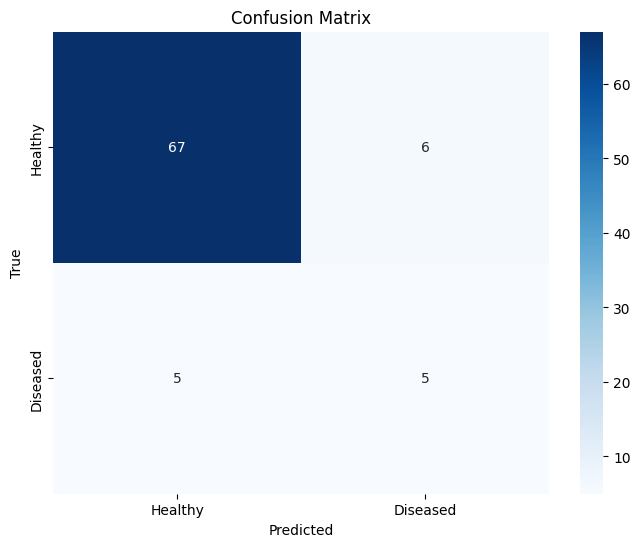

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_generator.reset()

# Get the true labels and predicted labels
y_true = []
y_pred = []

for i in range(len(validation_generator)):
    X, y = validation_generator.next()
    y_true.extend(y)
    y_pred.extend(simple_cnn.predict(X))

# Convert predictions and true labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.round(y_pred).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diseased'], yticklabels=['Healthy', 'Diseased'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 38ms/step


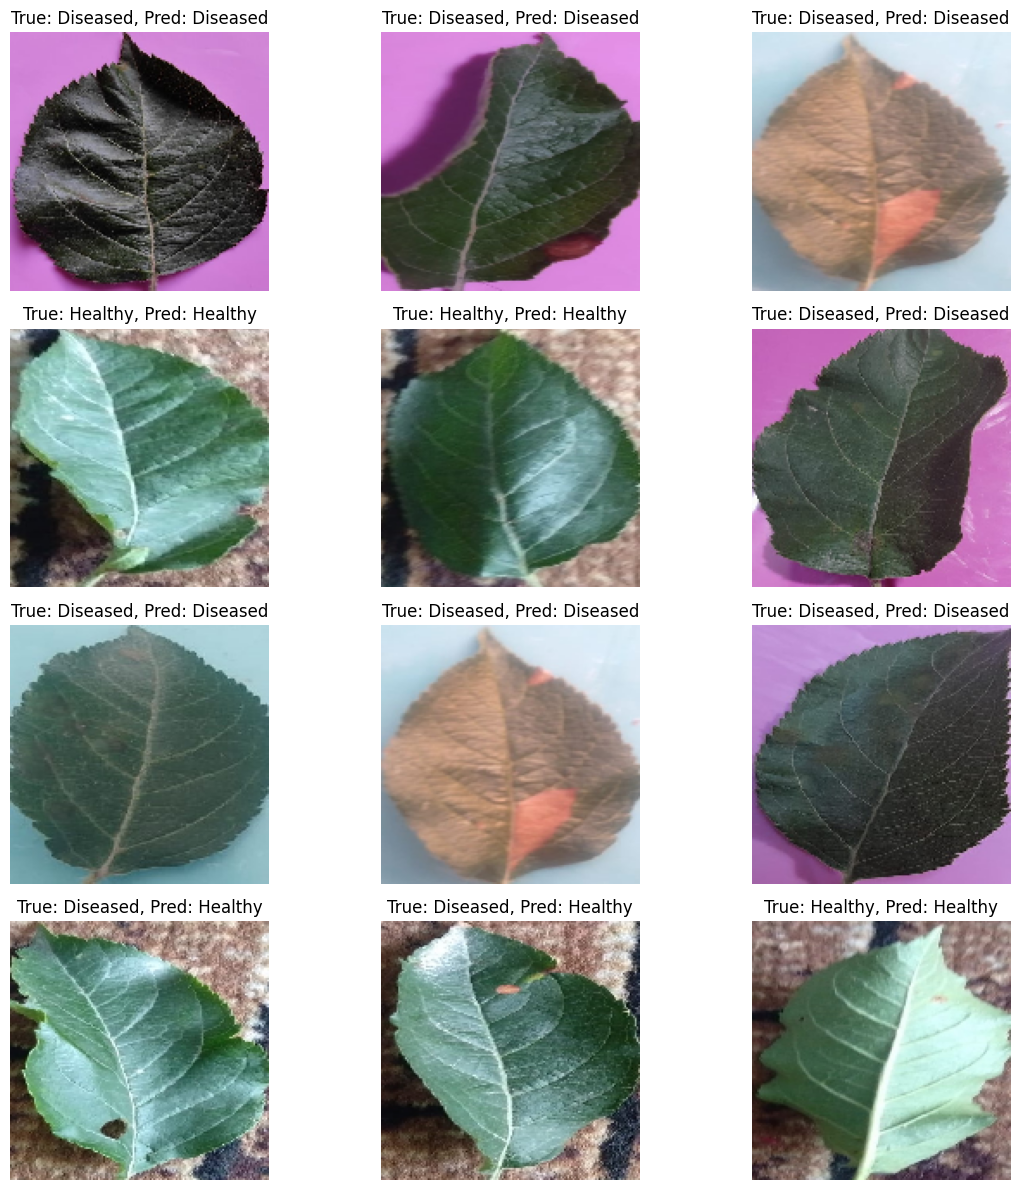

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images with predictions
def plot_predictions(model, generator, class_names, num_images=12):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 3, i + 1)
        img, label = next(generator)
        img = img[0]  # Get the first image from the batch
        prediction = model.predict(np.expand_dims(img, axis=0))
        pred_label = np.round(prediction).astype(int)[0][0]
        true_label = int(label[0])  # Get the true label
        plt.imshow(img)
        plt.title(f'True: {class_names[true_label]}, Pred: {class_names[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Class names (considering binary classification: 1 for Healthy, 0 for Diseased)
class_names = ['Diseased', 'Healthy']

# Reset the validation generator to start from the beginning
validation_generator.reset()

# Plot predictions
plot_predictions(simple_cnn, validation_generator, class_names)
